# IAPS ANALISYS 

In this notebook we analyse the power in predicting IMT from the activation maps during the IAPS task. By means of a nested cross-validation, we assessed the generalization of the model (outer loop) and the optimal value of the regularisation LASSO coefficient (inner loop). All the folds in the outer and inner loop have been generated in a stratified fashion way such that there are not differences between the training and test set in IMT as measured by a Kolmogorv-Smirnov test.

In [2]:
# Here the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as opj
import seaborn as sns
import os
import time
from joblib import Parallel, delayed

from nilearn import masking, image, plotting
from sklearn.model_selection import (StratifiedKFold, cross_validate, cross_val_predict)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model.coordinate_descent import _alpha_grid
from scipy.stats import ks_2samp, pearsonr
from sklearn.utils import resample
from glob import glob
import re

In [3]:
# The working directory
work_dir = os.path.abspath("../")

In [4]:
# For reproducibility
RANDOM_STATE = 0

In [73]:
meta_data = pd.read_csv(opj(work_dir, "data", "data_merged_n337_stratifiedY.csv"))

In [46]:
# Mask with the greatest voxel coverage  
grey_mask = image.load_img(img=opj(work_dir,"data", "reslicedER_grey25grey25.nii"))
amygdala_mask = image.load_img(img=opj(work_dir, "data", "Amygdala.nii"))

In [7]:
X = masking.apply_mask([image.load_img(opj(work_dir, "data", "ER_LookNegative_LookNeutral", 'activation_maps', 
                                     'ER_LNegLNeu_' + str(sub_id) + '.nii'))\
                               for sub_id in meta_data['id'].values],
                              mask_img, ensure_finite=True)


y = meta_data['mavg'].values
study_labels = meta_data['study'].values

y_discrete = np.digitize(y, np.quantile(y, q=[0.2, 0.4, 0.6, 0.8]))

In [8]:
print("The number of subjects for AHAB-2 is %d and for PIP is %d" % (sum(study_labels=='AHAB'), sum(study_labels=='PIP')))

The number of subjects for AHAB-2 is 179 and for PIP is 158


In [9]:
X_ahab = X[study_labels=='AHAB']
X_pip = X[study_labels=='PIP']

y_ahab = y[study_labels=='AHAB']
y_pip = y[study_labels=='PIP']

In [10]:
y_ahab_discrete = np.digitize(y_ahab, np.quantile(y_ahab, q=[0.2, 0.4, 0.6, 0.8]))
y_pip_discrete = np.digitize(y_pip, np.quantile(y_ahab, q=[0.2, 0.4, 0.6, 0.8]))

In [78]:
AHAB_subjects = meta_data[study_labels=='AHAB']['id']
PIP_subjects = meta_data[study_labels=='PIP']['id']

Create and the test loop for optimisitation is balanced

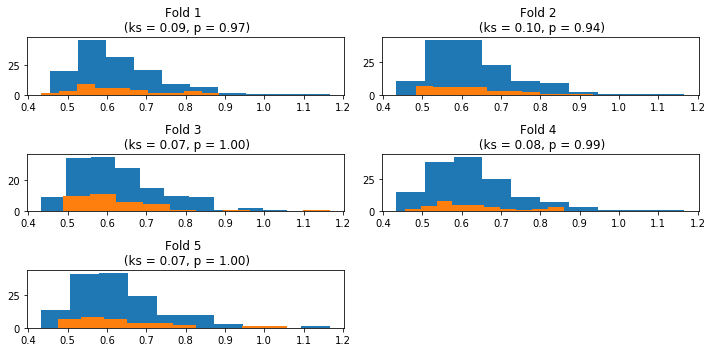

In [11]:
cv_ahab = StratifiedKFold(n_splits=5,  
                          shuffle = True, 
                          random_state=RANDOM_STATE).split(np.zeros(len(y_ahab_discrete)), y_ahab_discrete)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, val_index) in enumerate(cv_ahab):
    
    y_train, y_val = y_ahab[train_index], y_ahab[val_index]
    
    axs[ii].hist(y_train, label="training")
    axs[ii].hist(y_val, label="validation")
    
    ks, p = ks_2samp(y_train, y_val)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

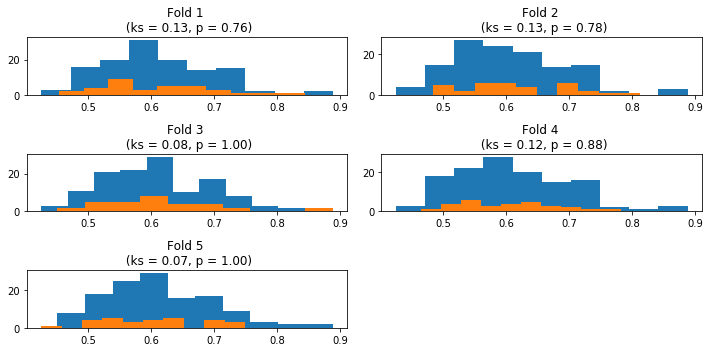

In [12]:
cv_pip = StratifiedKFold(n_splits=5,  
                         shuffle = True, 
                         random_state=RANDOM_STATE).split(np.zeros(len(y_pip_discrete)), y_pip_discrete)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, val_index) in enumerate(cv_pip):
    
    y_train, y_val = y_pip[train_index], y_pip[val_index]
    
    axs[ii].hist(y_train, label= "training")
    axs[ii].hist(y_val, label = "validation")
    
    ks, p = ks_2samp(y_train, y_val)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

In [13]:
def fit_lasso(X_train, X_val, y_train, y_val, alpha):

    clf = Lasso(alpha=alpha, max_iter=1e5, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    
    return mean_squared_error(y_val, clf.predict(X_val))


def estim_opt(X, y, y_discrete):

    cv_inner = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE)

    # This will generate a grid of alphas to optimise the model
    alphas = _alpha_grid(X, y, n_alphas = 100)

    XX_trains, XX_vals = [], []
    yy_trains, yy_vals = [], []
    
    for train_index, val_index in cv_inner.split(np.zeros(len(y)), y_discrete):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        ss = StandardScaler(with_std=False)
        pca = PCA()

        X_train_transform = pca.fit_transform(ss.fit_transform(X_train))
        X_val_transform = pca.transform(ss.transform(X_val))

        XX_trains.append(X_train_transform)
        XX_vals.append(X_val_transform)
        yy_trains.append(y_train)
        yy_vals.append(y_val)

    res_loops = []
    for X_train, X_val, y_train, y_val in zip(XX_trains, XX_vals, yy_trains, yy_vals):

        res_loops.append(Parallel(n_jobs=10)(delayed(fit_lasso)(X_train, X_val, y_train, y_val, alpha) for alpha in alphas))

    res_loops = np.array(res_loops)

    opt_alpha = alphas[np.argmin(res_loops.mean(axis=0))]

    #refit all data with this optimal alpha
    pip =  make_pipeline(StandardScaler(with_std=False), PCA(), 
                         Lasso(alpha=opt_alpha, max_iter=1e5, random_state=RANDOM_STATE))

    pip.fit(X, y)
    return pip

In [66]:
y_pred, y_true = [], []

model_ahab = estim_opt(X_ahab, y_ahab, y_ahab_discrete)

y_pred.append(model_ahab.predict(X_pip))
y_true.append(y_pip)

model_pip = estim_opt(X_pip, y_pip, y_pip_discrete)

y_pred.append(model_pip.predict(X_ahab))
y_true.append(y_ahab)

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [67]:
r, p = pearsonr(y_true, y_pred)
r

0.24257131230843287

In [68]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred), size=len(y_pred))
    
    corr_boot.append(np.corrcoef(y_pred[boot_idxs],
                                 y_true[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

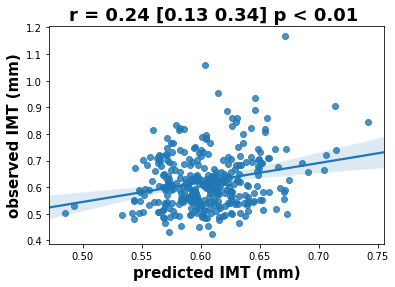

In [69]:
sns.regplot(y_pred, y_true)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [27]:
observed_model = estim_opt(X, y, y_discrete)

weight_map = np.matmul(observed_model.named_steps['pca'].components_.T, 
                       observed_model.named_steps['lasso'].coef_)

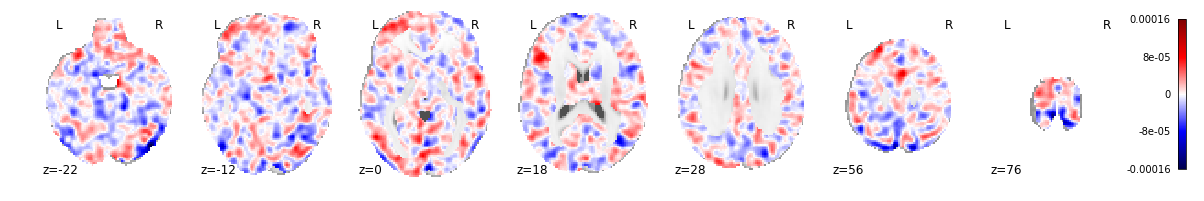

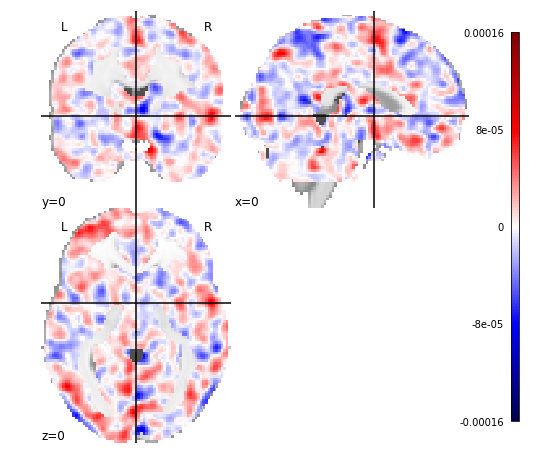

In [28]:
plotting.plot_stat_map(masking.unmask(weight_map, mask_img=mask_img), 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(masking.unmask(weight_map, mask_img=mask_img), 
                       threshold=0., display_mode='tiled', cut_coords=(0,0,0), cmap=plt.cm.seismic)

## Confidence intervals by bootstrap

In [24]:
n_boot = 1000

t_0 = time.time()

weight_map_boots = []

random_seed = 0
ii = 0
while ii < n_boot:
    try:
        X_boot, y_boot, y_discrete_boot = resample(X, y, y_discrete, 
                                                   stratify = study_labels,
                                                   random_state = random_seed)


        model_boot = estim_opt(X_boot, y_boot, y_discrete_boot)

        weight_map_boots.append(np.matmul(model_boot.named_steps['pca'].components_.T, 
                                          model_boot.named_steps['lasso'].coef_))

        if ii % 100 == 0:
            print("bootstrap iteration %d finished " % ii)
        ii += 1
        random_seed += 1          
    except:
        random_seed += 1 
        pass

t_f = time.time()
weight_map_boots = np.array(weight_map_boots)

bootstrap iteration 0 finished 
bootstrap iteration 100 finished 
bootstrap iteration 200 finished 
bootstrap iteration 300 finished 
bootstrap iteration 400 finished 
bootstrap iteration 500 finished 
bootstrap iteration 600 finished 
bootstrap iteration 700 finished 
bootstrap iteration 800 finished 
bootstrap iteration 900 finished 


In [29]:
np.savez_compressed("resuts_iaps.npz", weight_map = weight_map, weight_map_boots = weight_map_boots)

In [30]:
alpha = 0.05

low_ci = np.quantile(weight_map_boots, q = alpha/(2), axis=0)
high_ci = np.quantile(weight_map_boots, q=1-alpha/(2), axis=0)

In [32]:
mask_sig = low_ci*high_ci > 0
print("the number of significant voxels = %d" % sum(mask_sig))

the number of significant voxels = 24338


In [36]:
weight_map_thr = masking.unmask(np.multiply(mask_sig, weight_map), mask_img=mask_img)

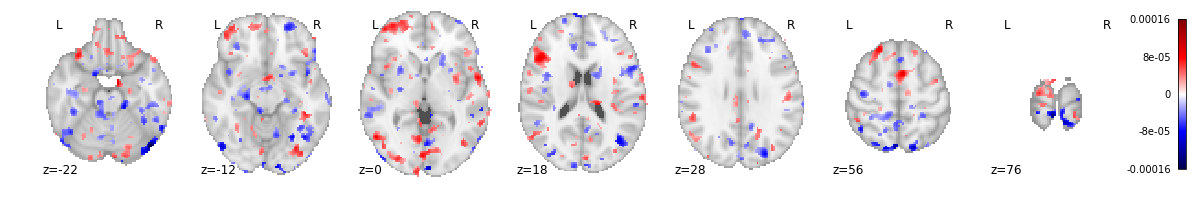

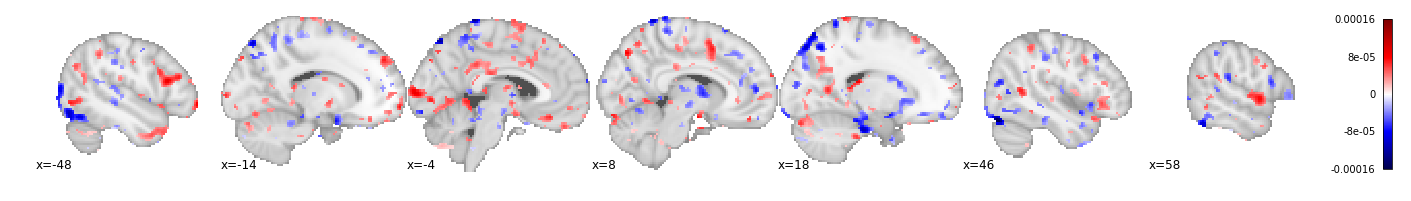

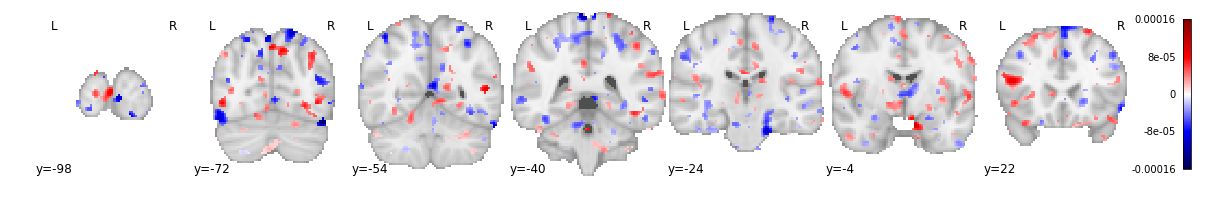

In [37]:
plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic)
pass

In [39]:
from nilearn.regions import connected_regions
voxel_size = 2 
k_voxels = 50

regions_extracted_img_pos, _ = connected_regions(masking.unmask(np.multiply(mask_sig, weight_map), 
                                                                mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

regions_extracted_img_neg, _ = connected_regions(masking.unmask(-1*np.multiply(mask_sig, weight_map), 
                                                                mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

In [40]:
new_data = np.zeros(mask_img.shape)

for img in image.iter_img(regions_extracted_img_pos):
    new_data += img.get_data().copy()

for img in image.iter_img(regions_extracted_img_neg):
    new_data -= img.get_data().copy()
    
img_vox_thr = image.new_img_like(mask_img, new_data)

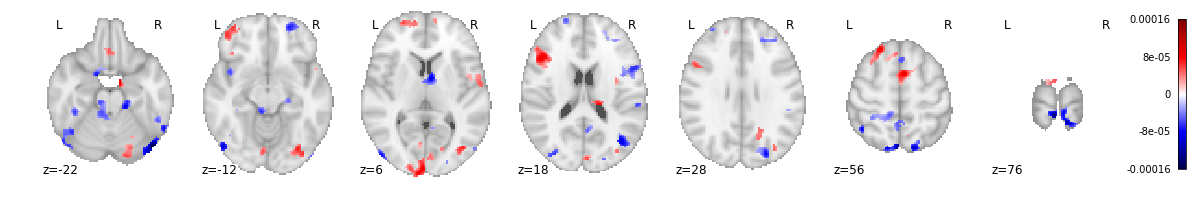

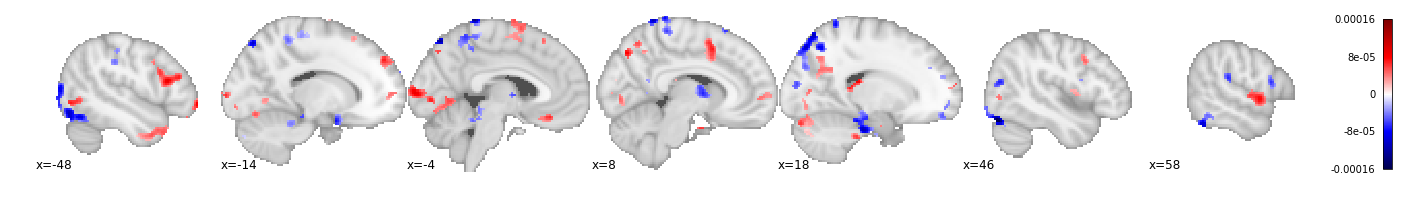

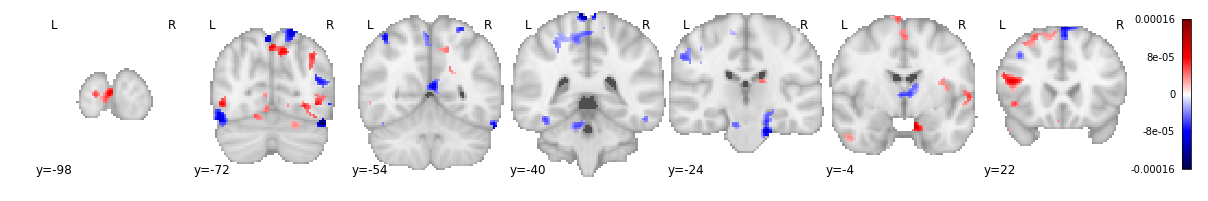

In [41]:
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic)
pass

In [45]:
print(" Number of voxels with p < 0.05 and k = 50 = %d " % sum(abs(img_vox_thr.get_data().flatten())>0))

 Number of voxels with p < 0.05 and k = 50 = 10230 


## ANCILLARY RESULTS

In [47]:
amygdala_mask_resampled = image.resample_to_img(amygdala_mask, target_img=grey_mask, interpolation='nearest')

In [50]:
X_amygdala = masking.apply_mask([image.load_img(opj(work_dir, "data", "ER_LookNegative_LookNeutral", 'activation_maps', 
                                     'ER_LNegLNeu_' + str(sub_id) + '.nii'))\
                               for sub_id in meta_data['id'].values],
                              amygdala_mask_resampled, ensure_finite=True)

In [51]:
X_amygdala_ahab = X_amygdala[study_labels=='AHAB']
X_amygdala_pip = X_amygdala[study_labels=='PIP']

In [62]:
y_pred_amygdala, y_true_amygdala = [], []

model_ahab = estim_opt(X_amygdala_ahab, y_ahab, y_ahab_discrete)

y_pred_amygdala.append(model_ahab.predict(X_amygdala_pip))
y_true_amygdala.append(y_pip)

model_pip = estim_opt(X_amygdala_pip, y_pip, y_pip_discrete)

y_pred_amygdala.append(model_pip.predict(X_amygdala_ahab))
y_true_amygdala.append(y_ahab)

y_pred_amygdala = np.concatenate(y_pred_amygdala)
y_true_amygdala = np.concatenate(y_true_amygdala)

In [63]:
r, p = pearsonr(y_true_amygdala, y_pred_amygdala)
r

-0.05523041683512018

In [64]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred_amygdala), size=len(y_pred_amygdala))
    
    corr_boot.append(np.corrcoef(y_pred_amygdala[boot_idxs],
                                 y_true_amygdala[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

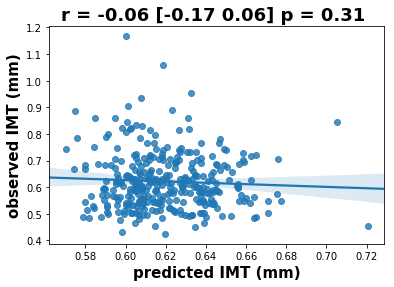

In [65]:
sns.regplot(y_pred_amygdala, y_true_amygdala)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

Addig age, sex and CMR as regressors between predicted and observed values

In [183]:
all_data = pd.read_csv("../data/all_data.csv")

In [184]:
# Map extreme values to NaNs
all_data.loc[all_data.waist_circumference > 100, "waist_circumference"] = pd.np.nan
all_data.loc[all_data.HDL > 200, "HDL"] = pd.np.nan
all_data.loc[all_data.triglycerides > 500, "triglycerides"] = pd.np.nan
all_data.loc[all_data.glucose > 500, "glucose"] = pd.np.nan

In [185]:
PIP_all_data = all_data.iloc[np.concatenate([np.where(all_data.ID==sub_id)[0] for sub_id in PIP_subjects]),:]
AHAB_all_data = all_data.iloc[np.concatenate([np.where(all_data.ID==sub_id)[0] for sub_id in AHAB_subjects]),:]

In [186]:
#check that the observed imt data is the same as here, meaning that they are in the same order
print(np.corrcoef(PIP_all_data.imt.values, y_pip)[0,1])
print(np.corrcoef(AHAB_all_data.imt.values, y_ahab)[0,1])

# Check if concantenated values as PIP and AHAB are the same used above
print(np.corrcoef(np.concatenate((PIP_all_data.imt.values, AHAB_all_data.imt.values)), y_true)[0,1])

1.0
0.999999999694524
0.9999999997966469


In [187]:
ss = StandardScaler()

In [188]:
z_stouffer_pip = np.nanmean(np.concatenate((ss.fit_transform(PIP_all_data.loc[:, ["waist_circumference"]]), 
                                            ss.fit_transform(-1*PIP_all_data.loc[:, ["HDL"]]),  
                                            ss.fit_transform(PIP_all_data.loc[:, ["triglycerides"]]), 
                                            ss.fit_transform(PIP_all_data.loc[:, ["glucose"]]), 
                                            ss.fit_transform(PIP_all_data.loc[:, ["SBP"]])), axis=1), axis=1)

z_stouffer_ahab = np.nanmean(np.concatenate((ss.fit_transform(AHAB_all_data.loc[:, ["waist_circumference"]]), 
                                            ss.fit_transform(-1*AHAB_all_data.loc[:, ["HDL"]]),  
                                            ss.fit_transform(AHAB_all_data.loc[:, ["triglycerides"]]), 
                                            ss.fit_transform(AHAB_all_data.loc[:, ["glucose"]]), 
                                            ss.fit_transform(AHAB_all_data.loc[:, ["SBP"]])), axis=1), axis=1)

In [189]:
# Build anciliary data frame with observed and predicted values, age, sex and cmr
anciliary_df = pd.DataFrame({'y_true' : y_true, 
                             'y_pred': y_pred, 
                             'age': np.concatenate((PIP_all_data.age.values, AHAB_all_data.age.values)),
                             'sex': np.concatenate((PIP_all_data.sex.values, AHAB_all_data.sex.values)),
                             'cmr': np.concatenate((z_stouffer_pip, z_stouffer_ahab)),
                            })

anciliary_df.head()

,y_true,y_pred,age,sex,cmr
0,0.547937,0.583296,34,2,-0.558493
1,0.626437,0.591484,32,2,-0.586047
2,0.611375,0.628400,33,1,0.204175
3,0.644250,0.612438,48,1,1.005113
4,0.589000,0.547532,39,1,1.369397


In [190]:
from statsmodels.formula import api as smf

In [191]:
print("Observed IMT vs CMR RSquared = {:.3f}".format(smf.ols('y_true ~ cmr', 
                                                            data=anciliary_df).fit().rsquared))
print("Observed IMT vs CMR + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + y_pred', 
                                                                            data=anciliary_df).fit().rsquared))

Observed IMT vs CMR RSquared = 0.135
Observed IMT vs CMR + Predicted IMT RSquared = 0.189


In [192]:
print("Observed IMT vs CMR + Age + Sex RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex)', 
                                                            data=anciliary_df).fit().rsquared))
print("Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex) + y_pred', 
                                                                        data=anciliary_df).fit().rsquared))

Observed IMT vs CMR + Age + Sex RSquared = 0.356
Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = 0.388


In [215]:
anciliary_df.loc[:,['age', 'y_pred', 'cmr']] = StandardScaler(with_std=False).fit_transform(anciliary_df.loc[:,['age', 'y_pred', 'cmr']])

In [216]:
smf.ols('y_true ~ C(sex)*y_pred', data=anciliary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     8.947
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           1.02e-05
Time:                        14:32:06   Log-Likelihood:                 299.23
No. Observations:                 337   AIC:                            -590.5
Df Residuals:                     333   BIC:                            -575.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6340      0.008     83.096      0.000       0.619       0.649
C(sex)[T.2]           -0.0247      0.011     -2.257      0.025      -0.046      -0.003
y_pred                 0.8632      0.218      3.968      0.000       0.435       1.291
C(sex)[T.2]:y_pred    -0.2373      0.319     -0.744      0.457      -0.864       0.390
==============================================================================
Omnibus:                       75.962   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.363
Skew:                           1.138   Prob(JB):                     1.24e-36
Kurtosis:                       5.569   Cond. No.                         74.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [217]:
smf.ols('y_true ~ age*y_pred', data = anciliary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     46.80
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           2.93e-25
Time:                        14:32:11   Log-Likelihood:                 345.44
No. Observations:                 337   AIC:                            -682.9
Df Residuals:                     333   BIC:                            -667.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6205      0.005    129.653      0.000       0.611       0.630
age            0.0071      0.001     10.364      0.000       0.006       0.008
y_pred         0.5597      0.139      4.018      0.000       0.286       0.834
age:y_pred     0.0419      0.019      2.232      0.026       0.005       0.079
==============================================================================
Omnibus:                       60.279   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.912
Skew:                           0.921   Prob(JB):                     1.68e-28
Kurtosis:                       5.391   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
smf.ols('y_true ~ cmr*y_pred', data=anciliary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     26.49
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           2.17e-15
Time:                        14:32:35   Log-Likelihood:                 322.23
No. Observations:                 337   AIC:                            -636.5
Df Residuals:                     333   BIC:                            -621.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6215      0.005    121.864      0.000       0.611       0.631
cmr            0.0555      0.008      7.200      0.000       0.040       0.071
y_pred         0.6860      0.148      4.620      0.000       0.394       0.978
cmr:y_pred     0.3057      0.238      1.282      0.201      -0.163       0.775
==============================================================================
Omnibus:                       49.928   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.348
Skew:                           0.900   Prob(JB):                     9.70e-18
Kurtosis:                       4.529   Cond. No.                         46.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
r, p = pearsonr(anciliary_df.loc[anciliary_df.age < anciliary_df.age.median(), "y_true"],
                anciliary_df.loc[anciliary_df.age < anciliary_df.age.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for under median Age r = {:.3f} (p = {:.3f})".format(r, p))

r, p = pearsonr(anciliary_df.loc[anciliary_df.age > anciliary_df.age.median(), "y_true"],
                anciliary_df.loc[anciliary_df.age > anciliary_df.age.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for over median Age r = {:.3f} (p = {:.3f})".format(r, p))

association Observed IMT vs Predicted IMT for under median Age r = 0.143 (p = 0.069)
association Observed IMT vs Predicted IMT for over median Age r = 0.278 (p = 0.000)


In [197]:
r, p = pearsonr(anciliary_df.loc[anciliary_df.cmr < anciliary_df.cmr.median(), "y_true"],
                anciliary_df.loc[anciliary_df.cmr < anciliary_df.cmr.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for under median CMR r = {:.3f} (p = {:.3f})".format(r, p))

r, p = pearsonr(anciliary_df.loc[anciliary_df.cmr > anciliary_df.cmr.median(), "y_true"],
                anciliary_df.loc[anciliary_df.cmr > anciliary_df.cmr.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for over median CMR r = {:.3f} (p = {:.3f})".format(r, p))

association Observed IMT vs Predicted IMT for under median CMR r = 0.243 (p = 0.002)
association Observed IMT vs Predicted IMT for over median CMR r = 0.222 (p = 0.004)
